Before starting, you will need to install some packages to reproduce the baseline.

In [121]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [111]:
import misvm

# Data architecture

After downloading or unzipping the downloaded files, your data tree must have the following architecture in order to properly run the notebook:
```
your_data_dir/
├── train_output.csv
├── train_input/
│   ├── images/
│       ├── ID_001/
│           ├── ID_001_tile_000_17_170_43.jpg
...
│   └── moco_features/
│       ├── ID_001.npy
...
├── test_input/
│   ├── images/
│       ├── ID_003/
│           ├── ID_003_tile_000_16_114_93.jpg
...
│   └── moco_features/
│       ├── ID_003.npy
...
├── supplementary_data/
│   ├── baseline.ipynb
│   ├── test_metadata.csv
│   └── train_metadata.csv
```

For instance, `your_data_dir = /storage/DATA_CHALLENGE_ENS_2022/`


This notebook aims to reproduce the baseline method on this challenge called `MeanPool`. This method consists in a logistic regression learnt on top of tile-level MoCo V2 features averaged over the slides.

For a given slide $s$ with $N_s=1000$ tiles and corresponding MoCo V2 features $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$, a slide-level average is performed over the tile axis.

For $j=1,...,2048$:

$$\overline{\mathbf{k_s}}(j) = \frac{1}{N_s} \sum_{i=1}^{N_s} \mathbf{K_s}(i, j) $$

Thus, the training input data for MeanPool consists of $S_{\text{train}}=344$ mean feature vectors $\mathbf{k_s}$, $s=1,...,S_{\text{train}}$, where $S_{\text{train}}$ denotes the number of training samples.

## Data loading

In [122]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("../")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [123]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    #X_train.append(np.mean(features, axis=0))
    X_train.append(features)
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [00:01<00:00, 201.65it/s]


In [129]:
X_train_unraveled = X_train.reshape(-1, 2048)

In [145]:
n_comp = 100
pca = PCA(n_components = n_comp, random_state=42)

pca.fit(X_train_unraveled)

PCA(n_components=100, random_state=42)

La proportion de variance expliquée par les 2 premières composantes est de: 0.15743099363179397
On a 75.28654602478407% de la variance expliquée


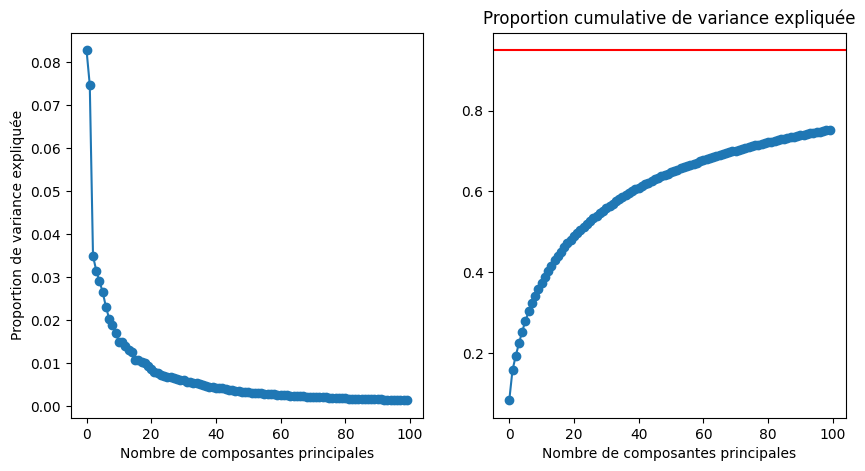

In [146]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_comp), pca.explained_variance_ratio_, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion de variance expliquée")
plt.subplot(1, 2, 2)
plt.plot(np.arange(n_comp), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(0.95, color = "red")
plt.xlabel("Nombre de composantes principales")
plt.title("Proportion cumulative de variance expliquée")
print(f"La proportion de variance expliquée par les 2 premières composantes est de: {np.sum(pca.explained_variance_ratio_[:2])}")

a = 0
i = 0
for i in range(n_comp):
    a += pca.explained_variance_ratio_[i]
    i+=1
print(f"On a {a*100}% de la variance expliquée")

In [147]:
X_train_transformed = pca.transform(X_train_unraveled)
X_train_transformed = X_train_transformed.reshape((344, 1000, n_comp))

# Clustering on tiles

In [133]:
n_centroids = 10
X_train_transformed_less_tiles = np.zeros((344, n_centroids, n_comp))

for i in tqdm(range(344)):
    kmeans = KMeans(n_clusters=n_centroids, random_state=42).fit(X_train_transformed[i])
    list_labels = kmeans.labels_.tolist()
    X_train_transformed_less_tiles[i] = np.array(kmeans.cluster_centers_)


100%|██████████| 344/344 [00:38<00:00,  9.00it/s]


# Multiple Instance SVM Training

In [159]:
classifier = misvm.NSK(kernel='linear', C=1.0)

In [154]:
classifier.fit(X_train_transformed[:, ::50, :], 2*y_train - 1)

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -9.7219e+01 -2.2843e+00  3e+03  5e+01  3e-12
 1: -1.5070e+00 -2.2823e+00  3e+01  6e-01  3e-12
 2: -5.2648e-01 -2.0294e+00  4e+00  5e-02  2e-13
 3: -4.1595e-01 -1.0996e+00  8e-01  3e-03  1e-14
 4: -4.6999e-01 -6.1107e-01  1e-01  5e-04  7e-15
 5: -5.0285e-01 -5.3817e-01  4e-02  1e-04  7e-15
 6: -5.1233e-01 -5.1838e-01  6e-03  1e-05  7e-15
 7: -5.1421e-01 -5.1491e-01  7e-04  8e-07  8e-15
 8: -5.1444e-01 -5.1453e-01  9e-05  9e-08  7e-15
 9: -5.1447e-01 -5.1448e-01  5e-06  5e-09  8e-15
10: -5.1448e-01 -5.1448e-01  1e-07  6e-11  8e-15
Optimal solution found.


In [158]:
y_predict = classifier.predict(X_train_transformed[:, ::50, :])
np.average(np.sign(y_predict) == 2*y_train - 1)

0.8023255813953488

In [73]:
y_predict

array([0.12334988, 0.58164512, 0.        , 0.12337656, 0.90765656,
       0.12334984, 0.        , 0.16504792, 0.22361179, 0.10600304,
       0.1233832 , 0.67288353, 0.26350879, 0.80449681, 0.77505871,
       0.16119066, 0.1305295 , 0.67594932, 0.28847679, 0.30370324,
       0.46296717, 0.        , 0.65917585, 0.30739505, 0.19667606,
       0.25903747, 0.96568172, 0.        , 0.84993432, 0.34956155,
       0.        , 0.38841677, 0.        , 0.12335503, 0.37182756,
       0.40641378, 0.11580922, 0.        , 0.        , 0.03183475,
       0.        , 0.07038087, 0.62477908, 0.12777901, 0.07237463,
       0.40402318, 1.        , 0.76455637, 0.12338351, 0.1214049 ,
       0.        , 0.59163469, 0.41135706, 0.96252837, 0.64861461,
       0.30275197, 0.3499494 , 0.23788122, 0.62134448, 0.51123259,
       1.        , 0.77969345, 0.10418168, 0.        , 0.58521385,
       0.12337457, 0.12334786, 0.97103554, 0.37919459, 0.30749289,
       0.899226  , 0.12334785, 0.12337873, 0.35432782, 0.12334

## 5-fold cross validation

In [161]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [163]:
aucs = []
classifiers = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train_transformed[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train_transformed[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        #lr = LogisticRegression(C=0.01, solver="liblinear")
        # fit it
        #lr.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        #preds_val = lr.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        classifier = misvm.NSK(kernel='linear', C=1.0)
        classifier.fit(X_fold_train[:, ::50, :], 2*y_fold_train - 1)
        preds_val = classifier.predict(X_fold_val)
        preds_val = np.clip(((preds_val + 1) / 2), 0, 1)
        auc = roc_auc_score(y_fold_val, preds_val)
        print(f"AUC on split {k} fold {fold}: {auc:.3f}")
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        classifiers.append(classifier)
        fold += 1
    print("----------------------------")
print(
    f"5-fold cross-validated AUC averaged over {k+1} repeats: "
    f"{np.mean(aucs):.3f} ({np.std(aucs):.3f})"
)

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -7.0851e+01 -2.2764e+00  2e+03  5e+01  2e-12
 1: -1.1994e+00 -2.2730e+00  3e+01  5e-01  2e-12
 2: -4.8774e-01 -1.9711e+00  4e+00  5e-02  2e-13
 3: -3.7853e-01 -1.1215e+00  8e-01  3e-03  2e-14
 4: -4.3198e-01 -5.7468e-01  1e-01  6e-04  9e-15
 5: -4.6500e-01 -4.9830e-01  3e-02  6e-05  9e-15
 6: -4.7269e-01 -4.8080e-01  8e-03  1e-05  9e-15
 7: -4.7491e-01 -4.7607e-01  1e-03  1e-06  1e-14
 8: -4.7527e-01 -4.7534e-01  7e-05  5e-08  1e-14
 9: -4.7529e-01 -4.7530e-01  3e-06  2e-09  9e-15
10: -4.7529e-01 -4.7529e-01  9e-08  4e-11  1e-14
Optimal solution found.
AUC on split 0 fold 0: 0.573
Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -7.0538e+01 -2.2338e+00  2e+03  5e+01  2e-12
 1: -1.2366e+00 -2.2295e+00  3e+01  5e-01  2e-12
 2: -4.9413e-01 -1.9395e+00  4e+00  5e-02  2e-13
 3: -3.9024e-01 -1.0614e+00  8e-01  3e-03  1e-14
 4: -4.3854e-01 -5.7547e-01  1e-01  6e-04  8e-15
 5: -4.6936e-01

# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [77]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(features)

X_test = np.array(X_test)

100%|██████████| 149/149 [00:00<00:00, 224.80it/s]


In [80]:
X_test_unraveled = X_test.reshape(-1, 2048)
X_test_transformed = pca.transform(X_test_unraveled)
X_test_transformed = X_test_transformed.reshape((149, 1000, n_comp))

In [90]:
X_test_transformed_less_tiles = np.zeros((149, n_centroids, n_comp))

for i in tqdm(range(149)):
    kmeans = KMeans(n_clusters=n_centroids, random_state=42).fit(X_test_transformed[i])
    X_test_transformed_less_tiles[i] = kmeans.cluster_centers_

100%|██████████| 149/149 [00:16<00:00,  9.07it/s]


In [91]:
X_test_transformed_less_tiles.shape

(149, 10, 205)

## Inference

In [94]:
preds_test = 0
# loop over the classifiers
for classifier in classifiers:
    y_classifier = classifier.predict(X_test_transformed_less_tiles)
    preds_test += np.clip(((y_classifier + 1) / 2), 0, 1)
    
# and take the average (ensembling technique)
preds_test = preds_test / len(classifiers)

In [98]:
preds_test[:30]

array([0.7275936 , 0.51464285, 0.28602693, 0.17325259, 0.08999926,
       0.87882369, 0.00518655, 0.62902098, 0.28535853, 0.25589364,
       0.16321913, 0.41472733, 0.57474195, 0.1732883 , 0.39815459,
       0.48770272, 0.27078173, 0.6351116 , 0.44019285, 0.53908218,
       0.52808396, 0.08242862, 0.09532265, 0.9179515 , 0.76761823,
       0.40688572, 0.9468021 , 0.738104  , 0.31863793, 0.30725438])

## Saving predictions

In [96]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.727594
1,ID_004.npy,0.514643
2,ID_008.npy,0.286027
3,ID_009.npy,0.173253
4,ID_010.npy,0.089999


# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [18]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    f"Number of images\n"
    "-----------------\n"
    f"Train: {len(train_images_files)}\n" # 344 x 1000 = 344,000 tiles
    f"Test: {len(test_images_files)}\n"  # 149 x 1000 = 149,000 tiles
    f"Total: {len(train_images_files) + len(test_images_files)}\n"  # 493 x 1000 = 493,000 tiles
)

Number of images
-----------------
Train: 0
Test: 0
Total: 0



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [12]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

In [14]:
print(ID_001_tiles)

[]


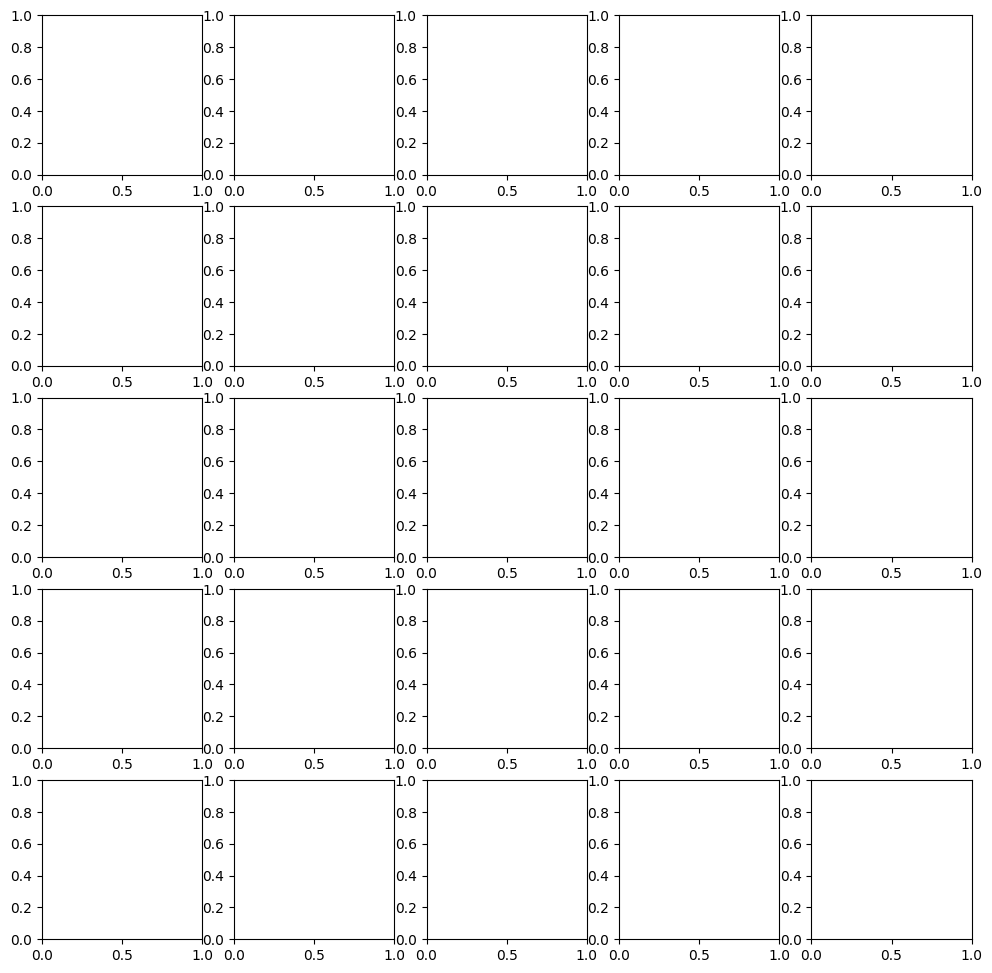

In [13]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({x}, {y})")
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [21]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [20]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



[]

In [29]:
submission.max()

Sample ID    ID_493.npy
Target         0.448932
dtype: object